##### This project uses an existing data set of sensor data. The data will be cleaned and manipulated as a learning device. The original data set that is imported is data from 8 co2 sensors, 1 temp sensor, and a humidity sensor. For the sake of this example I will only be looking at the data from the temperature sensor. The scope of this project is to classify the event based on the data. In the actul experiement the team induced the sensors by adding either a banana or wine into the clean room. In this example I have classified the banana data as an event and the wine data as a false event.

### Import libraries and necessary data

In [34]:
import numpy as np
import pylab as pl
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

## Import metadata and clean ()
metadata = np.loadtxt('HT_Sensor_metadata.dat', skiprows=1, dtype=str)
metadata_aux = np.array( metadata[:,[0,3,4]], dtype=float )

## Import dataset
dataset = np.loadtxt('HT_Sensor_dataset.dat', skiprows=1)

### I will begin by looking at an isolated instance of an event and non-event to gain better understanding

In [35]:
event = 17
false_event = 19

### The metadata table containes important information includng the data classification and time data reguarding each instance. I need to get the start time and duration of each induction so we can identify a smaller data scope.

In [36]:
## Get desired metadata for **event**
event_md = metadata_aux[event]
start_time = event_md[1] #start time
end_time = start_time + event_md[2] #duration

## Get desired metadata for **false_event**
false_event_md = metadata_aux[false_event]
false_start_time = false_event_md[1] #start time
false_end_time = false_start_time + false_event_md[2] #duration

In [37]:
all_temp = dataset[:,[0,1,10]] #all id's, time's, and temps

In [38]:
event_data = all_temp[all_temp[:,0]==event,1:] #get all instances with id of **event**
event_data[:,0] += start_time # set time atribute to time from metadata

false_data = all_temp[all_temp[:,0]==false_event,1:] #get all instances with id of **false_event**
false_data[:,0] += false_start_time # set time atribute to time from metadata

### Snapshop of one event and one non-event

In [39]:
#snapshot of current working data
print(event_data[:10])
print('---------------------------')
print(false_data[:10])

[[ 5.540107 27.9875  ]
 [ 5.540385 27.9868  ]
 [ 5.540663 27.9862  ]
 [ 5.540941 27.9856  ]
 [ 5.541219 27.9851  ]
 [ 5.541509 27.9846  ]
 [ 5.541787 27.9841  ]
 [ 5.542065 27.9837  ]
 [ 5.542343 27.9834  ]
 [ 5.542621 27.9831  ]]
---------------------------
[[21.540074 27.0557  ]
 [21.540352 27.0551  ]
 [21.54063  27.0547  ]
 [21.540908 27.0542  ]
 [21.541193 27.0538  ]
 [21.541471 27.0534  ]
 [21.541749 27.0503  ]
 [21.542027 27.0474  ]
 [21.542305 27.0448  ]
 [21.542592 27.0424  ]]


### Plot one event 
#### Here I use the metadata to normalize the time for better data visulization 5.5 = 5:30 am
#### The section of the graph that is sliced is the duration of the induction

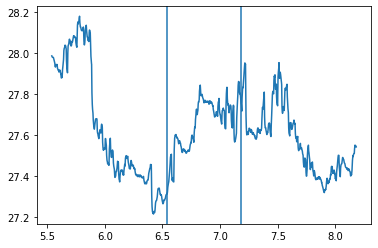

In [40]:
plt.plot(event_data[:,0],event_data[:,1])
plt.axvline(start_time)
plt.axvline(end_time)
plt.show()

### Plot false event

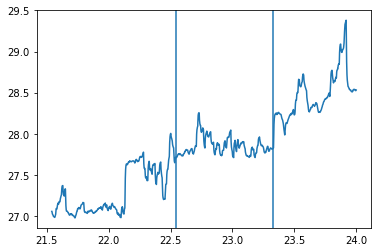

In [41]:
plt.plot(false_data[:,0],false_data[:,1])
plt.axvline(false_start_time)
plt.axvline(false_end_time)
plt.show()

In [42]:
#subset of metadata table
test = metadata 
event = test[test[:,2] == 'banana'] #get all instances of **banana*
non_event = test[test[:,2] == 'wine'] #get all instances of **wine**
null = test[test[:,2] == 'background'] #get all instances of **wine**

In [43]:
print(test[:10])
print('---------------------------------------------')
print(event[:10])

[['0' '07-04-15' 'banana' '13.49' '1.64']
 ['1' '07-05-15' 'wine' '19.61' '0.54']
 ['2' '07-06-15' 'wine' '19.99' '0.66']
 ['3' '07-09-15' 'banana' '6.49' '0.72']
 ['4' '07-09-15' 'wine' '20.07' '0.53']
 ['5' '07-10-15' 'banana' '16.38' '0.80']
 ['6' '07-11-15' 'wine' '11.19' '0.95']
 ['7' '07-12-15' 'banana' '8.17' '0.49']
 ['8' '07-12-15' 'wine' '10.41' '1.17']
 ['9' '07-15-15' 'banana' '9.35' '0.61']]
---------------------------------------------
[['0' '07-04-15' 'banana' '13.49' '1.64']
 ['3' '07-09-15' 'banana' '6.49' '0.72']
 ['5' '07-10-15' 'banana' '16.38' '0.80']
 ['7' '07-12-15' 'banana' '8.17' '0.49']
 ['9' '07-15-15' 'banana' '9.35' '0.61']
 ['10' '07-15-15' 'banana' '12.70' '1.18']
 ['11' '07-17-15' 'banana' '14.85' '0.60']
 ['13' '07-21-15' 'banana' '8.00' '0.48']
 ['15' '07-22-15' 'banana' '16.54' '0.72']
 ['16' '07-22-15' 'banana' '20.60' '1.32']]


In [44]:
event_ids = event[:,0] #all id's of **banana**
non_event_ids = non_event[:,0]
null_ids = null[:,0]

In [45]:
all_temp = dataset[:,[0,1,10]] #all id's, time's, and temps
all_temp[:10]

array([[ 0.      , -0.99975 , 26.2257  ],
       [ 0.      , -0.999472, 26.2308  ],
       [ 0.      , -0.999194, 26.2365  ],
       [ 0.      , -0.998916, 26.2416  ],
       [ 0.      , -0.998627, 26.2462  ],
       [ 0.      , -0.998349, 26.2503  ],
       [ 0.      , -0.998071, 26.2541  ],
       [ 0.      , -0.997793, 26.2575  ],
       [ 0.      , -0.997515, 26.2606  ],
       [ 0.      , -0.997227, 26.2626  ]])

In [46]:
time_list = []
temp_list = []
for i in event_ids:
    x = all_temp[np.in1d(all_temp[:,0],float(i))]
    time = x[:,[1]]
    time_list.append(time)
    temp = x[:,[2]]
    temp_list.append(temp)
time_list = np.concatenate(time_list).ravel()
temp_list = np.concatenate(temp_list).ravel()
event_df = pd.DataFrame(list(zip(time_list, temp_list)), columns =['Time', 'Temp']) 
event_df['Event'] = 1

In [47]:
time_list = []
temp_list = []
for i in non_event_ids:
    x = all_temp[np.in1d(all_temp[:,0],float(i))]
    time = x[:,[1]]
    time_list.append(time)
    temp = x[:,[2]]
    temp_list.append(temp)
time_list = np.concatenate(time_list).ravel()
temp_list = np.concatenate(temp_list).ravel()
non_event_df = pd.DataFrame(list(zip(time_list, temp_list)), columns =['Time', 'Temp']) 
non_event_df['Event'] = 0

# DF BELOW HERE

In [48]:
df = pd.concat([event_df, non_event_df], ignore_index=True, sort=True)
df['Time'] = df['Time'].astype(float)

In [49]:
df = df[df.Time > 0]
df = df[df.Time < 0.1 ]

In [50]:
df['Event'].value_counts()

0    11723
1    11344
Name: Event, dtype: int64

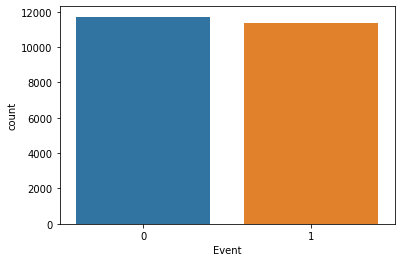

In [51]:
sns.countplot(df['Event'])

#### Similar amounts of data for events and non-events

In [52]:
#seperate dataset as response variables
X = df.drop('Event', axis = 1) #use all values but event
y = df['Event'] #use event

In [53]:
#Train and Test
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [54]:
# Apply standard scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Random Forest Classifier

In [26]:
# Create Model
# Better for classifications
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

# Check model preformance
print(classification_report(y_test,pred_rfc))
print(confusion_matrix(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2343
           1       0.93      0.93      0.93      2271

    accuracy                           0.93      4614
   macro avg       0.93      0.93      0.93      4614
weighted avg       0.93      0.93      0.93      4614

[[2175  168]
 [ 148 2123]]


### SVM Classifier

In [83]:
#Create model 
#SVM typically preforms better on smaller numbers,raw data, data-streaming?
clf = svm.SVC()
clf.fit(X_train,y_train)
pred_clf = clf.predict(X_test)

# Check model preformance
print(classification_report(y_test,pred_clf))
print(confusion_matrix(y_test,pred_clf))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53      2343
           1       0.56      0.68      0.61      2271

    accuracy                           0.58      4614
   macro avg       0.58      0.58      0.57      4614
weighted avg       0.58      0.58      0.57      4614

[[1119 1224]
 [ 733 1538]]


### Neural Network

In [84]:
#Create Model
#Better for text analysis (series and sources), pictures, requires a lot of data
mlpc= MLPClassifier(hidden_layer_sizes=(11,11,11),max_iter=500)
mlpc.fit(X_train,y_train)
pred_mlpc = mlpc.predict(X_test)

# Check model preformance
print(classification_report(y_test,pred_mlpc))
print(confusion_matrix(y_test,pred_mlpc))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2343
           1       0.71      0.71      0.71      2271

    accuracy                           0.71      4614
   macro avg       0.71      0.71      0.71      4614
weighted avg       0.71      0.71      0.71      4614

[[1689  654]
 [ 669 1602]]


## Testing model

In [85]:
# Accuracy score
cm = accuracy_score(y_test,pred_rfc)
cm

0.9325964456003468

In [86]:
#Sort data by time
df = df.sort_values(by='Time')
df

,Event,Temp,Time
432207,0,26.2516,0.000002
42847,1,26.1998,0.000009
332823,0,26.8330,0.000010
283336,1,27.0332,0.000011
66506,1,28.9147,0.000015
...,...,...,...
514661,0,28.2083,0.099985
301084,1,27.3921,0.099985
205955,1,27.3883,0.099992
363519,0,27.4684,0.099992


In [2]:
X_new = [[25.8,0.2]]
X_new =sc.transform(X_new)
y_new = rfc.predict(X_new)
y_new

NameError: name 'sc' is not defined

## Clean sensor dataset

In [55]:
# Change data scope to first 6 minuets of induction
df = pd.DataFrame(data=dataset)
#df = df[df[1] > 0 ]
#df = df[df[1] < .1 ]
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0.0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0.0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0.0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0.0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736
...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99.0,1.675182,12.6224,10.5805,10.7432,12.1775,12.6498,17.2926,6.20449,7.05966,27.7282,54.1532
928987,99.0,1.675460,12.6236,10.5796,10.7436,12.1780,12.6511,17.2918,6.20444,7.05980,27.7312,54.1423
928988,99.0,1.675738,12.6244,10.5795,10.7437,12.1782,12.6524,17.2907,6.20451,7.05967,27.7339,54.1324
928989,99.0,1.676016,12.6243,10.5797,10.7440,12.1784,12.6532,17.2904,6.20468,7.05969,27.7364,54.1235


In [56]:
df.columns= ['Id','Time','Sens-1','Sens-2','Sens-3','Sens-4','Sens-5','Sens-6','Sens-7','Sens-8','Temp','Co2']
df.reset_index(drop=True,inplace=True)
df['Event'] = df['Id'].isin(event_ids)
df.to_csv('sensor-sl.csv')
df

,Id,Time,Sens-1,Sens-2,Sens-3,Sens-4,Sens-5,Sens-6,Sens-7,Sens-8,Temp,Co2,Event
0,0.0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,True
1,0.0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,True
2,0.0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,True
3,0.0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,True
4,0.0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99.0,1.675182,12.6224,10.5805,10.7432,12.1775,12.6498,17.2926,6.20449,7.05966,27.7282,54.1532,False
928987,99.0,1.675460,12.6236,10.5796,10.7436,12.1780,12.6511,17.2918,6.20444,7.05980,27.7312,54.1423,False
928988,99.0,1.675738,12.6244,10.5795,10.7437,12.1782,12.6524,17.2907,6.20451,7.05967,27.7339,54.1324,False
928989,99.0,1.676016,12.6243,10.5797,10.7440,12.1784,12.6532,17.2904,6.20468,7.05969,27.7364,54.1235,False


In [57]:
df

,Id,Time,Sens-1,Sens-2,Sens-3,Sens-4,Sens-5,Sens-6,Sens-7,Sens-8,Temp,Co2,Event
0,0.0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,True
1,0.0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,True
2,0.0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,True
3,0.0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,True
4,0.0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
928986,99.0,1.675182,12.6224,10.5805,10.7432,12.1775,12.6498,17.2926,6.20449,7.05966,27.7282,54.1532,False
928987,99.0,1.675460,12.6236,10.5796,10.7436,12.1780,12.6511,17.2918,6.20444,7.05980,27.7312,54.1423,False
928988,99.0,1.675738,12.6244,10.5795,10.7437,12.1782,12.6524,17.2907,6.20451,7.05967,27.7339,54.1324,False
928989,99.0,1.676016,12.6243,10.5797,10.7440,12.1784,12.6532,17.2904,6.20468,7.05969,27.7364,54.1235,False
